In [1]:
%pip install lime

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt; plt.style.use('dark_background')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import accuracy_score


In [3]:
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", 
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
             "srv_diff_host_rate", "dst_host_count","dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]
kdd_data_10percent = pd.read_csv("KDD99/kddcup_data_10_percent_corrected.csv", names = col_names)
kdd_data_10percent.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
minMaxScaler = MinMaxScaler()

In [5]:
#Initially, we will use all features
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]
features = kdd_data_10percent[num_features].astype(float)
features.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Apply Min-Max scaling to each column separately
features_scaled = features.copy()
for column in features.columns:
    column_data = features[column].values.reshape(-1, 1)
    features_scaled[column] = minMaxScaler.fit_transform(column_data)

labels = kdd_data_10percent['label'].copy()
labels[labels != 'normal.'] = 'attack.'
labels = labels.map({'normal.': 0, 'attack.': 1})
labels.value_counts()

label
1    396743
0     97278
Name: count, dtype: int64

Text(0.5, 0.92, '3D PCA Plot of K-Means Clusters')

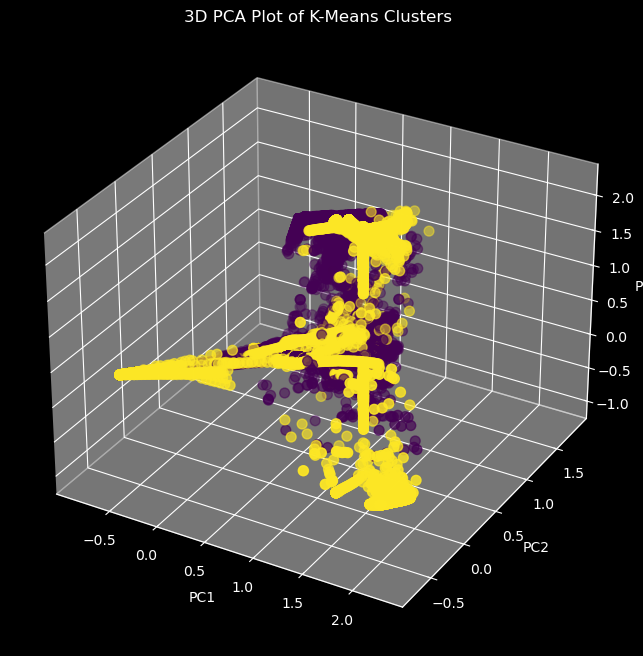

In [7]:
# Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features_scaled)

# Create a DataFrame with the PCA results
pca_df_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_result['PC1'],
                     pca_df_result['PC2'],
                     pca_df_result['PC3'],
                     c=labels,
                     cmap='viridis', s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Plot of K-Means Clusters')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, labels, test_size=0.2, random_state=42)

In [9]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 16.121 seconds


In [10]:
#Calculating out the accuracy
from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

Accuracy is 0.9978.


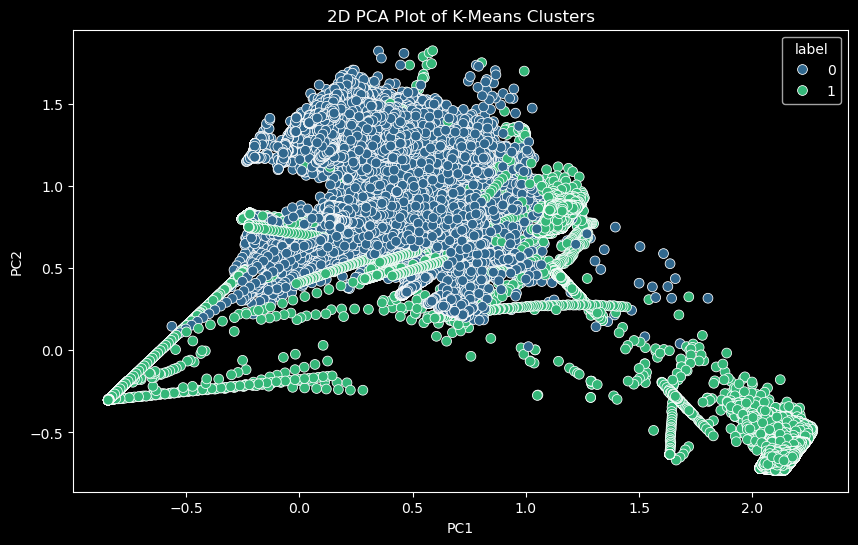

In [11]:
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Create a DataFrame with the PCA results
pca_df_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plot 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_result, x='PC1', y='PC2', hue=labels, palette='viridis', s=50)
plt.title('2D PCA Plot of K-Means Clusters')
plt.show()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, labels, test_size=0.2, random_state=42)

In [13]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 17.46 seconds


In [14]:
#Calculating out the accuracy
from sklearn.metrics import accuracy_score
pred = clf.predict(X_test)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

Accuracy is 0.9946.


In [15]:
columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
            ,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
            ,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
            ,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count'
            ,'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate'
            ,'outcome','level']

nsl_kdd = pd.read_csv("NSL_KDD/KDDTrain+.txt", names = columns)
nsl_kdd.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [16]:
nsl_kdd.loc[nsl_kdd['outcome'] == "normal", "outcome"] = 'normal'
nsl_kdd.loc[nsl_kdd['outcome'] != 'normal', "outcome"] = 'attack'
labels = nsl_kdd['outcome'].copy()
labels = labels.map({'normal': 0, 'attack': 1})
labels.value_counts()

outcome
0    67343
1    58630
Name: count, dtype: int64

In [17]:
features = ['duration','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
            ,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations'
            ,'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate'
            ,'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count'
            ,'dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate'
            ,'level']
X_train = nsl_kdd[features]
y_train = labels

nsl_kdd_2 = pd.read_csv("NSL_KDD/KDDTest+.txt", names = columns)
nsl_kdd_2.loc[nsl_kdd_2['outcome'] == "normal", "outcome"] = 'normal'
nsl_kdd_2.loc[nsl_kdd_2['outcome'] != 'normal', "outcome"] = 'attack'
labels_2 = nsl_kdd_2['outcome'].copy()
labels_2 = labels_2.map({'normal': 0, 'attack': 1})

X_test = nsl_kdd_2[features]
y_test = labels_2

In [18]:
# Apply Min-Max scaling to each column separately
X_train_scaled = X_train.copy()
for column in X_train.columns:
    column_data = X_train[column].values.reshape(-1, 1)
    X_train_scaled[column] = minMaxScaler.fit_transform(column_data)

X_test_scaled = X_test.copy()
for column in X_test.columns:
    column_data = X_test[column].values.reshape(-1, 1)
    X_test_scaled[column] = minMaxScaler.fit_transform(column_data)

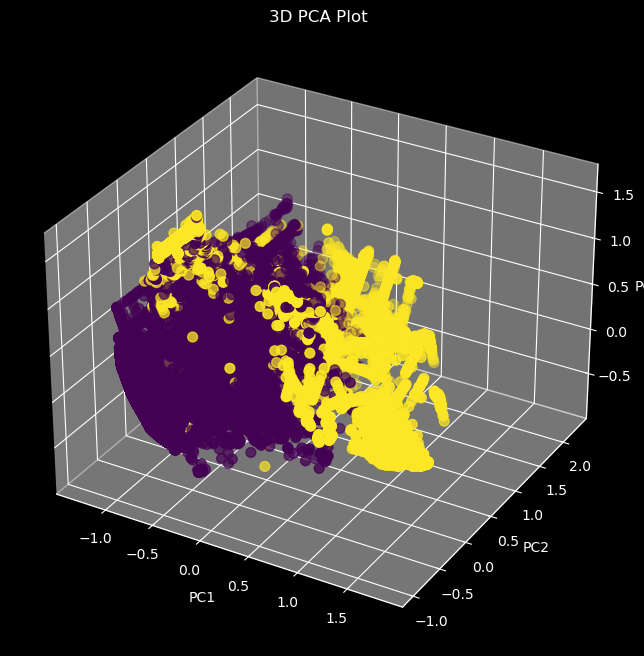

In [19]:
# Apply PCA
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_scaled)

# Create a DataFrame with the PCA results
pca_df_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])

# Plot 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_result['PC1'],
                     pca_df_result['PC2'],
                     pca_df_result['PC3'],
                     c=y_train,
                     cmap='viridis', s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Plot')

### Apply PCA to test data aswell
X_test_pca = pca.transform(X_test_scaled)

In [20]:
#Training a classifier
clf = RandomForestClassifier(random_state=0)
t0 = time()
clf.fit(pca_result, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 12.087 seconds.


In [21]:
pred = clf.predict(X_test_pca)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

Accuracy is 0.7641.


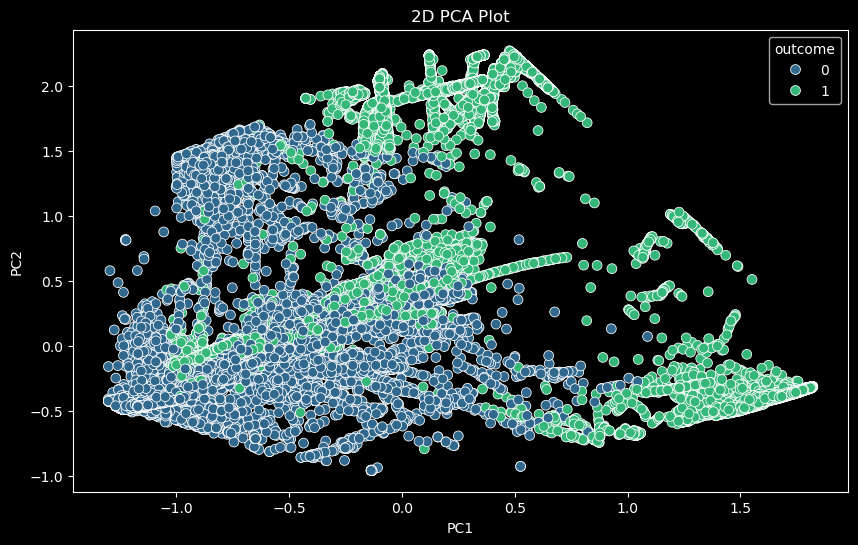

In [22]:
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train_scaled)

pca_df_result = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

# Plot 2D scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df_result,
                x='PC1',
                y='PC2',
                hue=y_train,
                palette='viridis',
                s=50)
plt.title('2D PCA Plot')
plt.show()

### Apply PCA to test data aswell
X_test_pca = pca.transform(X_test_scaled)

In [23]:
#Training a classifier
clf = RandomForestClassifier(random_state=0)
t0 = time()
clf.fit(pca_result, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 11.923 seconds.


In [24]:
pred = clf.predict(X_test_pca)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

Accuracy is 0.7626.


In [25]:
### LIME explanation with and without PCA

In [26]:
#Predictions on the test data
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train_scaled, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

pred = clf.predict(X_test_scaled)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

Trained in 6.717 seconds
Accuracy is 0.7971.


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


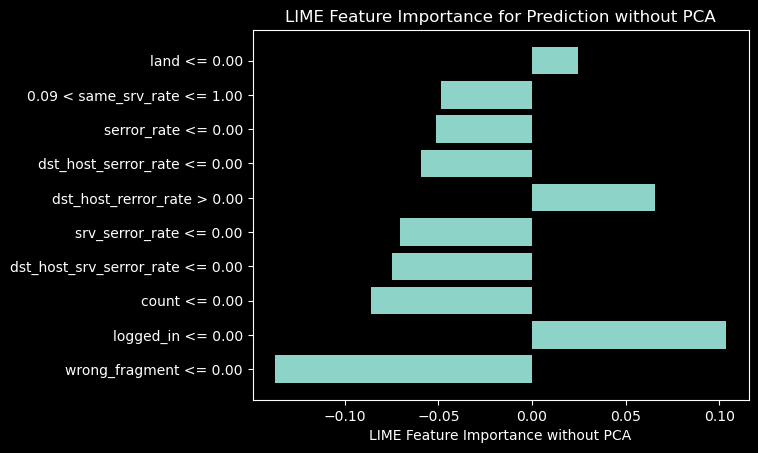

In [27]:
# Get the class names
class_names = [0, 1]

# Get the feature names
feature_names = list(X_train.columns)

# Fit the Explainer on the training data set using the LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_scaled.values, feature_names =     
                                 features,
                                 class_names = class_names, 
                                 mode = 'classification')

# Select an instance for explanation (replace index with the index of the instance you want to explain)
instance_index = 0
instance = X_train_scaled.iloc[[instance_index]]

# Explain the prediction for the selected instance
explanation = explainer.explain_instance(instance.values[0], clf.predict_proba)

# Visualize the explanation
lime_values = explanation.as_list()

# Create a bar plot to visualize feature importances
features, values = zip(*lime_values)
plt.barh(features, values)
plt.xlabel('LIME Feature Importance without PCA')
plt.title('LIME Feature Importance for Prediction without PCA')
plt.savefig('images/lime_feature_importance_non_pca.png')
plt.show()

In [28]:
#Predictions on the test data
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(pca_df_result, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

pred = clf.predict(X_test_pca)
acc = accuracy_score(pred, y_test)
print ("Accuracy is {}.".format(round(acc,4)))

Trained in 11.817 seconds


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Accuracy is 0.7626.


/opt/conda/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


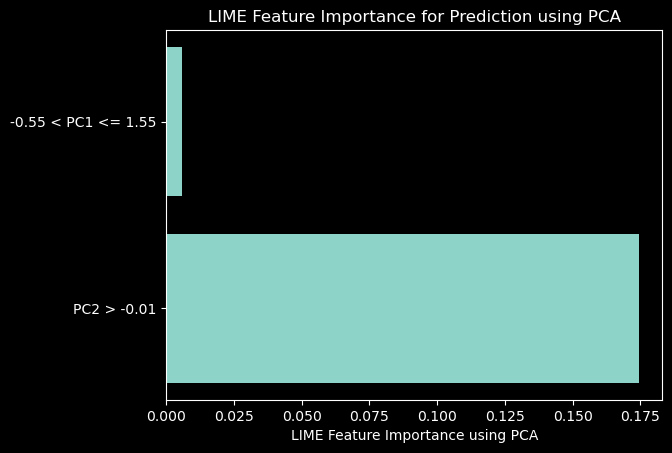

In [29]:
# Create a LIME explainer on the PCA-transformed data
explainer = LimeTabularExplainer(pca_df_result.values,
                                                   feature_names=['PC1', 'PC2', 'PC3'],
                                                   class_names=[0, 1], 
                                                   mode='classification')

# Select an instance for explanation (replace index with the index of the instance you want to explain)
instance_index = 0
instance = pca_df_result.iloc[[instance_index]]

lime_explanation = explainer.explain_instance(instance.values[0], clf.predict_proba)

# Visualize the explanation
lime_values = lime_explanation.as_list()


# Create a bar plot to visualize feature importances
features, values = zip(*lime_values)
plt.barh(features, values)
plt.xlabel('LIME Feature Importance using PCA')
plt.title('LIME Feature Importance for Prediction using PCA')
plt.savefig('images/lime_feature_importance_pca.png')
plt.show()